# Alien detection - Mask
In questo notebook è riportata un metodo d'indabine delle maschere al fine di pulire il dataset da immagini fuori contesto: in questo caso immagini del suolo di marte con sovrapposizione della faccia di un alieno.


In [ ]:
from google.colab import drive
drive.mount("/gdrive")

%cd /gdrive/My Drive/Colab Notebooks/AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1nsevQt0AHkv619Fg5omWFTVxhMjZS3lK/Homework 2


In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 0


In [ ]:
seed = 42

## ⏳ Load the Data

In [ ]:
data = np.load("Preprocessing/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


**Osservazione**: Il dataset contiene il training set e il test set. Il training set è costituito dalle immagini e le relative maschere, mentre il test set è costituito dalle sole immagini. Tutte le immagini e le maschere sono di dimensioni 64x128 e ne abbiamo 2615 nel training set e 10022 nel test set.

In [ ]:
# Check color value of images
print(f"Min value: {np.min(X_train)}")
print(f"Max value: {np.max(X_train)}")

Min value: 2.0
Max value: 254.0


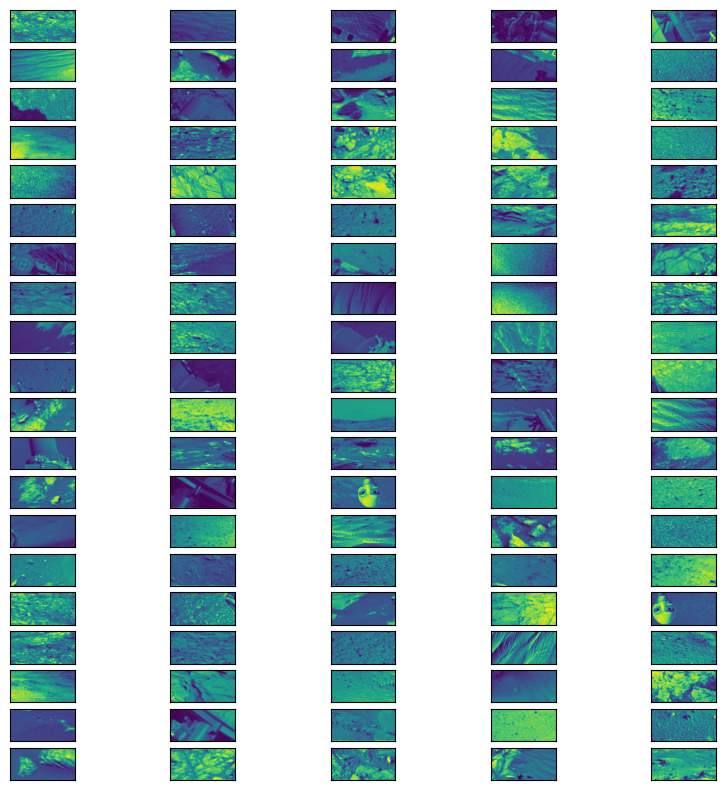

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(20, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

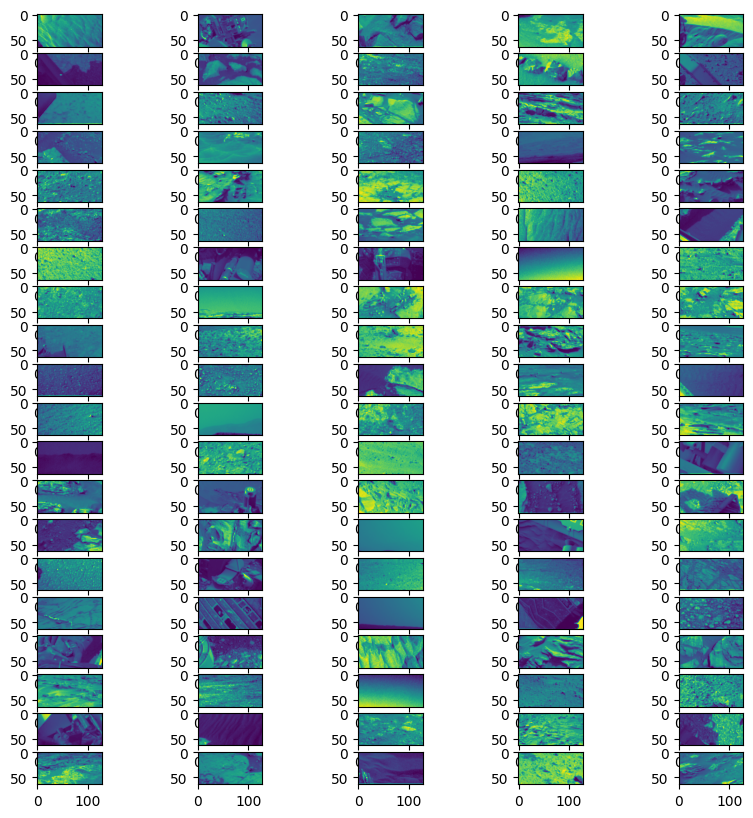

In [ ]:
# Visualize 25 image of X_test
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(20, 5, i + 1)
    plt.grid(False)
    plt.imshow(X_test[i+2000])
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

# Define colors for each class
class_colors = {
    0: "black",     # Background
    1: "brown",     # Soil
    2: "gray",      # Bedrock
    3: "yellow",    # Sand
    4: "darkgreen"  # Big Rock
}
cmap = ListedColormap([class_colors[key] for key in sorted(class_colors.keys())])

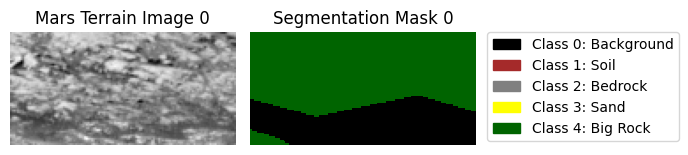

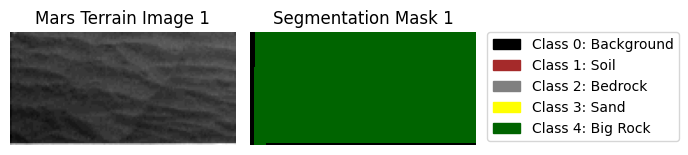

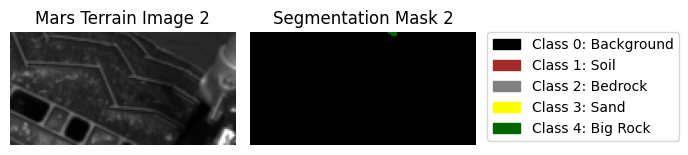

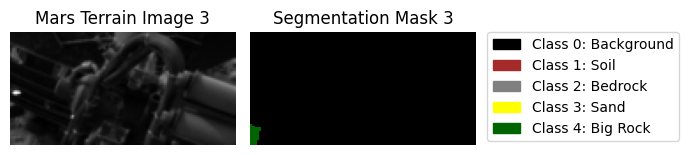

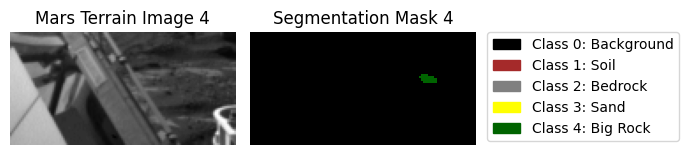

In [ ]:
# Prepare the legend
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=class_colors[i], label=f"Class {i}: {label}")
                  for i, label in enumerate(["Background", "Soil", "Bedrock", "Sand", "Big Rock"])]

# Display a range of images
def display_images_with_masks(X_train, y_train, start, end):
    for i in range(start, end):
        image = X_train[i]
        mask = y_train[i]

        # Plot the image and mask
        plt.figure(figsize=(7, 5))

        # Grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Mars Terrain Image {i}")
        plt.axis("off")

        # Mask with class colors
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap=cmap, interpolation="none")
        plt.title(f"Segmentation Mask {i}")
        plt.axis("off")

        # Add legend
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()

# Call the function for a range of images
display_images_with_masks(X_train, y_train, start=0, end=5)

#### Outliers removes
Controllo se ci sono maschere duplicate

In [ ]:
import numpy as np
import hashlib

def hash_label(label):
    """
    Generate a hash for a given label array to identify duplicates.
    """
    label_bytes = label.tobytes()
    return hashlib.md5(label_bytes).hexdigest()

# Generate hashes for all labels
label_hashes = [hash_label(label) for label in y_train]

# Find indices of identical labels
from collections import defaultdict

hash_to_indices = defaultdict(list)
for idx, h in enumerate(label_hashes):
    hash_to_indices[h].append(idx)

# Filter out groups with more than one image
duplicate_groups = {h: indices for h, indices in hash_to_indices.items() if len(indices) > 1}

# Display duplicates
for h, indices in duplicate_groups.items():
    print(f"Duplicate group {h}: {indices}")
print(len(h))

Duplicate group af08f371d20e13636ac025a65ca5f235: [5, 127, 165, 397, 559, 792, 797, 806, 965, 1267, 1371, 1489, 1505, 1545, 1600, 1650, 1801, 1971, 1980, 2119, 2198, 2244, 2302, 2385, 2425, 2461]
Duplicate group c5b9f7b327f8aef27113a9ddb51e7476: [9, 109, 163, 190, 233, 267, 306, 368, 410, 431, 548, 569, 593, 614, 618, 768, 919, 933, 994, 1060, 1074, 1305, 1451, 1567, 1638, 1811, 1869, 1882, 1895, 1916, 2012, 2025, 2032, 2037, 2113, 2349, 2447, 2451, 2484, 2612]
Duplicate group a385b49cc8404ce93eec4ca6291d5ff4: [13, 43, 67, 83, 88, 134, 247, 300, 309, 458, 474, 488, 504, 523, 544, 558, 567, 578, 599, 601, 644, 656, 661, 670, 704, 727, 788, 845, 859, 899, 948, 973, 974, 984, 993, 1120, 1138, 1189, 1219, 1334, 1336, 1338, 1410, 1413, 1506, 1553, 1563, 1564, 1573, 1710, 1722, 1723, 1732, 1739, 1777, 1792, 1796, 1880, 1893, 1918, 1926, 1939, 1973, 1984, 2027, 2059, 2061, 2062, 2074, 2082, 2089, 2102, 2106, 2123, 2152, 2170, 2212, 2258, 2261, 2266, 2306, 2311, 2319, 2336, 2348, 2401, 2426, 2

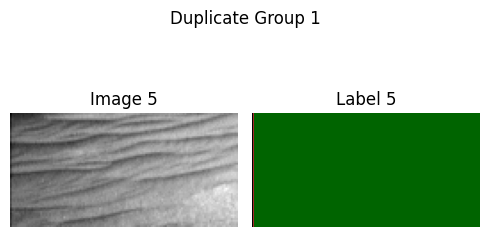

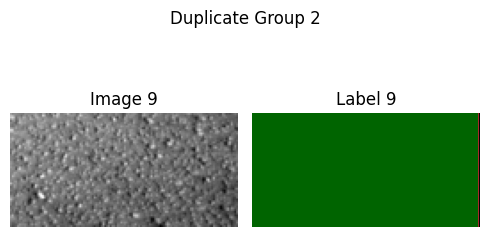

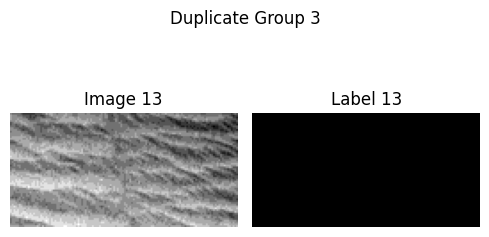

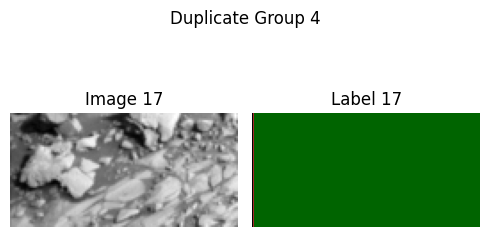

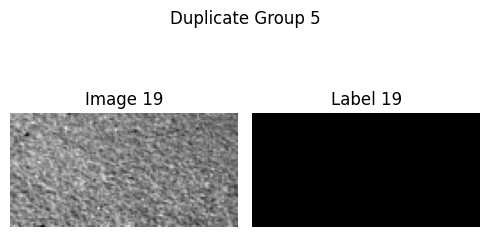

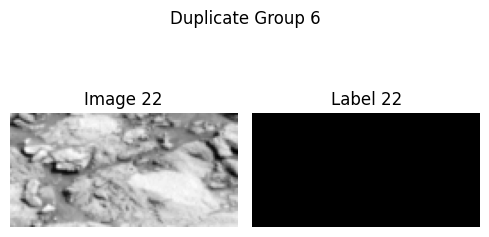

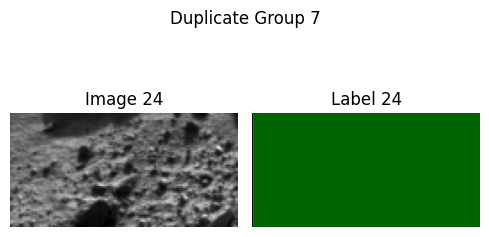

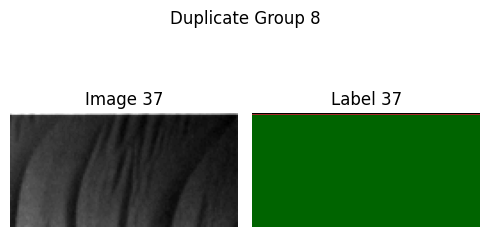

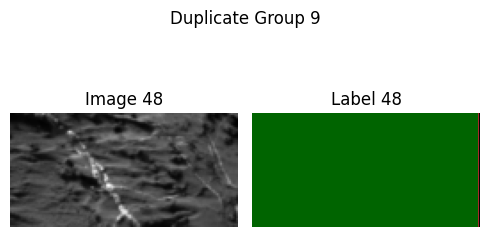

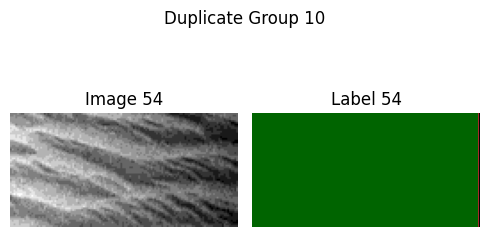

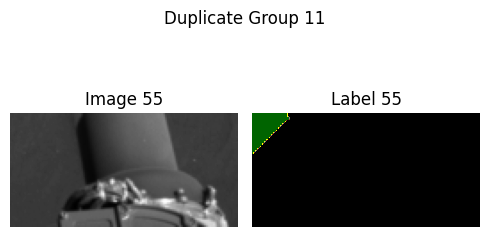

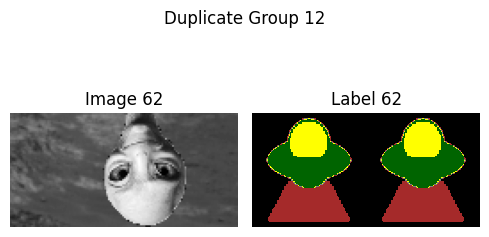

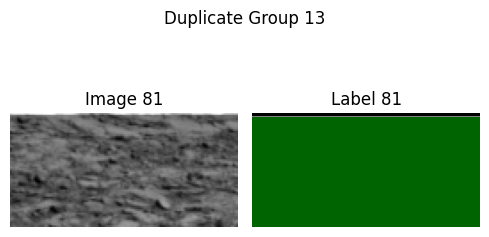

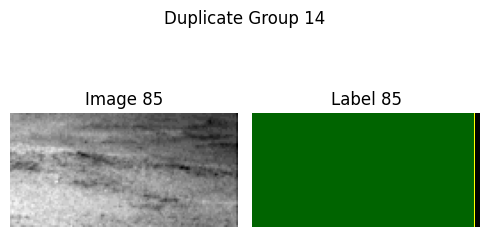

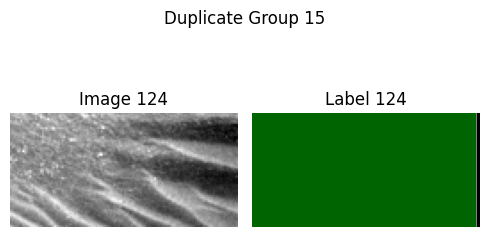

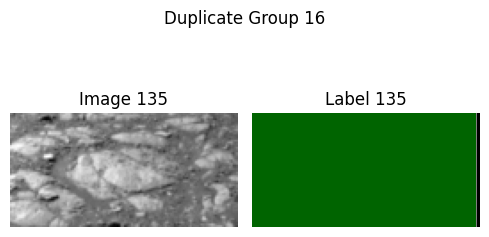

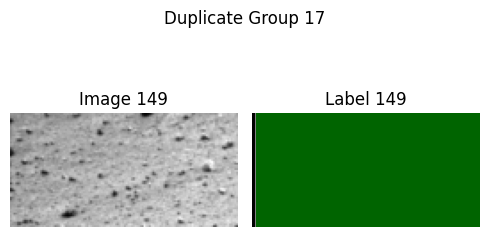

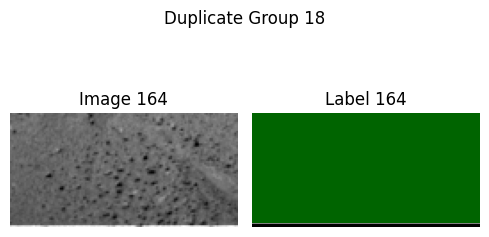

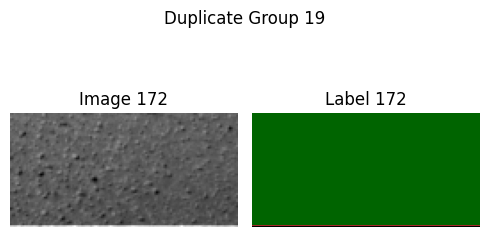

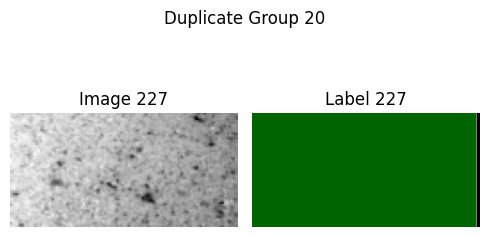

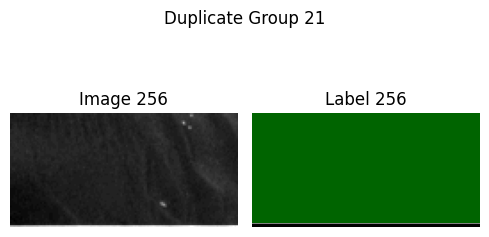

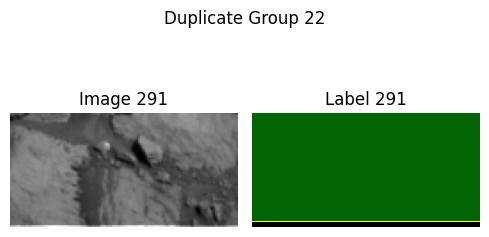

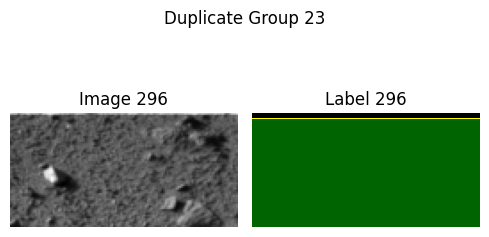

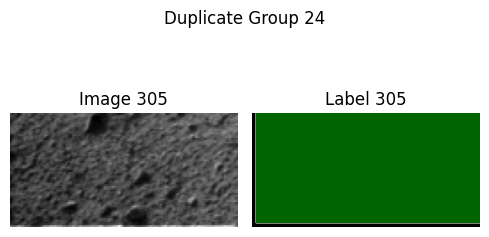

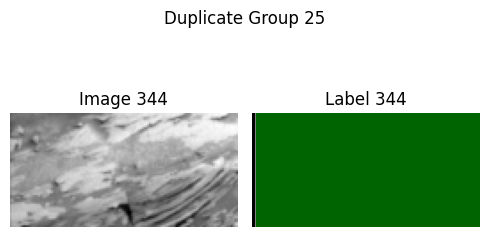

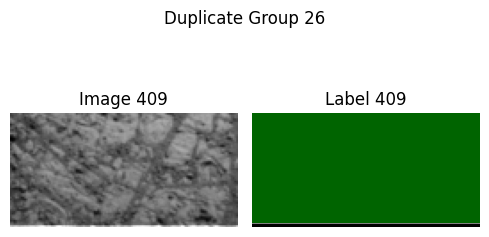

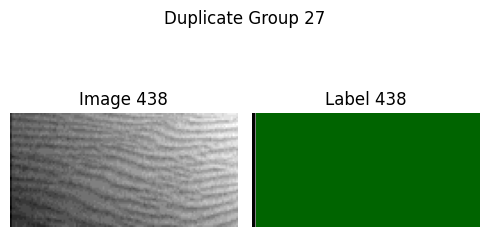

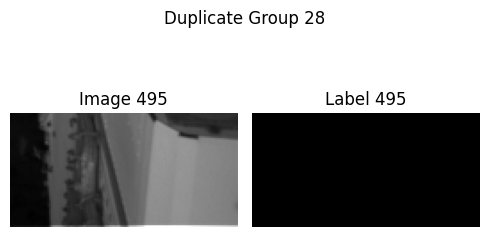

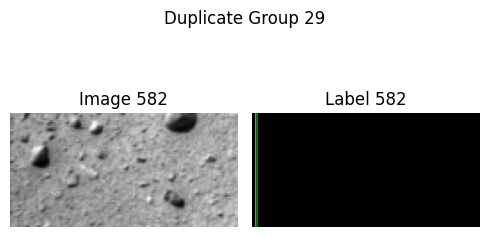

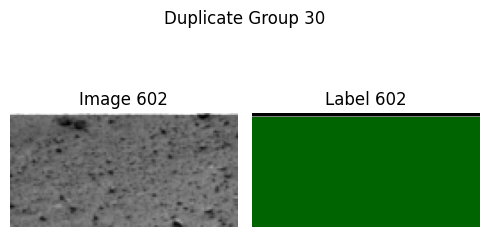

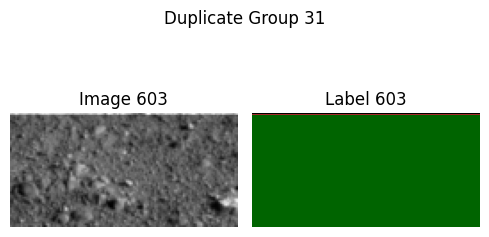

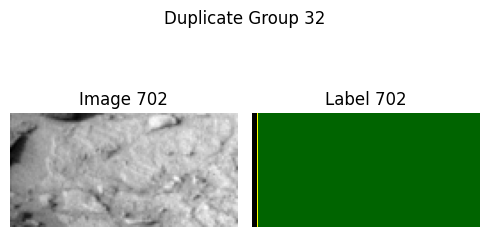

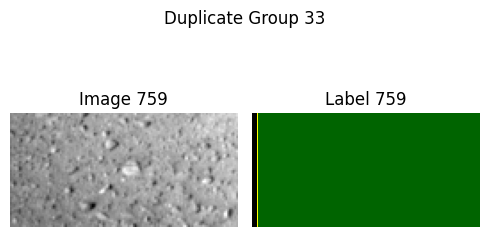

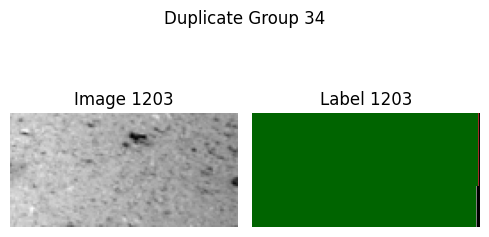

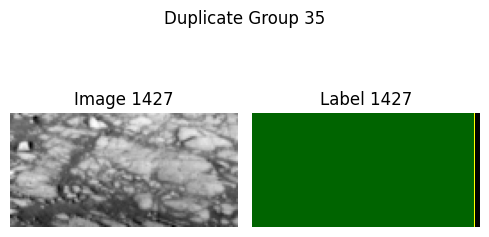

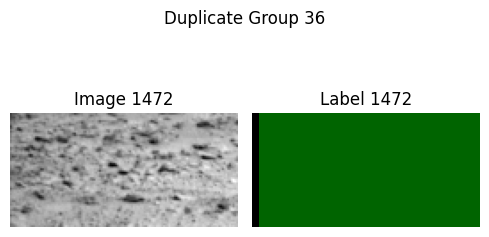

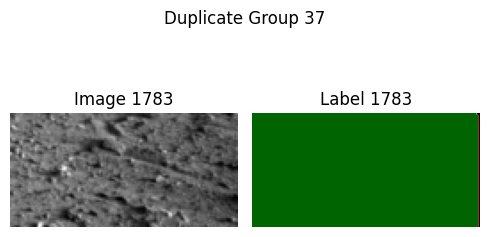

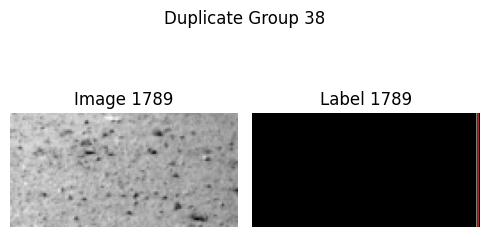

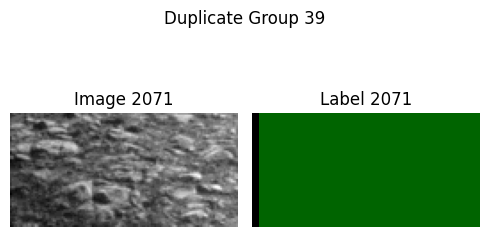

In [ ]:
# Visualize one image and its true label for each group of duplicates
for idx, (h, indices) in enumerate(duplicate_groups.items(), start=1):
    # Get the first image and its corresponding label in the group
    image_idx = indices[0]  # Take the first index from the group
    image = X_train[image_idx]
    label = y_train[image_idx]

    # Plot the image and label side by side
    plt.figure(figsize=(5, 3))
    plt.suptitle(f"Duplicate Group {idx}")

    # Input image
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Image {image_idx}")
    plt.axis('off')

    # True label
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap=cmap)
    plt.title(f"Label {image_idx}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Data la realisticità del dataset decido di eliminare solo le immagini con gli alieni.

In [ ]:
def visualize_duplicates_for_label(selected_label_hash):
    """
    Visualize all images corresponding to a selected label hash (duplicate group).
    """
    if selected_label_hash not in duplicate_groups:
        print(f"No duplicate group found for hash: {selected_label_hash}")
        return

    # Get the indices for the selected label hash
    indices = duplicate_groups[selected_label_hash]
    print(f"Visualizing {len(indices)} images for duplicate group {selected_label_hash}...")

    # Calculate number of rows and columns for the grid layout
    n_images = len(indices)
    cols = 6  # Set a fixed number of columns (you can change this if you like)
    rows = (n_images // cols) + (1 if n_images % cols != 0 else 0)

    # Visualize the true label and all corresponding images
    plt.figure(figsize=(cols * 3, rows * 3))  # Dynamically adjust the figure size based on the number of images

    # Display the true label in the first subplot
    label = y_train[indices[0]]  # All images in the group share the same label
    plt.subplot(rows, cols, 1)
    plt.imshow(label, cmap=cmap)
    plt.title("True Label")
    plt.axis('off')

    # Display each image corresponding to the label
    for i, image_idx in enumerate(indices):
        # Ensure we're within the valid grid range
        plt.subplot(rows, cols, i + 2)  # Start from the second subplot
        plt.imshow(X_train[image_idx].squeeze(), cmap='gray')
        plt.title(f"Image {image_idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: Select a label hash to visualize
selected_hash = list(duplicate_groups.keys())[11]
visualize_duplicates_for_label(selected_hash)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Filtra gli indici del gruppo 11
group_to_remove = list(duplicate_groups.items())[11]
hash_to_remove = group_to_remove[0]  # Hash corrispondente
indices_to_remove = group_to_remove[1]  # Indici del gruppo 11

# Crea nuove liste senza gli indici da rimuovere
X_train = np.delete(X_train, indices_to_remove, axis=0)
y_train = np.delete(y_train, indices_to_remove, axis=0)

print(f"Removed {len(indices_to_remove)} images associated at group {hash_to_remove}.")
print(f"Train images shape: {X_train.shape}")
print(f"Train labels shape: {y_train.shape}")

Removed 110 images associated at group 6d1c485f0a55ea81753b5c6cf66fca1a.
Train images shape: (2505, 64, 128)
Train labels shape: (2505, 64, 128)


In [ ]:
def visualize_images_with_label_in_prediction(label_to_check=4):
    """
    Visualize all images where at least one pixel is classified as the given label.
    """
    # Find all images where at least one pixel is classified as label_to_check
    indices = []

    for i, label in enumerate(y_train):
        # For each image, check if any pixel in the predicted mask is of label 'label_to_check'
        if np.any(label == label_to_check):  # Check if any pixel matches the label_to_check
            indices.append(i)

    if not indices:
        print(f"No images found with label {label_to_check} in any pixel.")
        return

    print(f"Visualizing {len(indices)} images where at least one pixel is classified as {label_to_check}...")

    # Calculate number of rows and columns for the grid layout
    n_images = len(indices)
    cols = 5  # Set a fixed number of columns
    rows = (n_images // cols) + (1 if n_images % cols != 0 else 0)

    # Visualize all images with the label in the mask
    plt.figure(figsize=(cols * 3, rows * 3))  # Dynamically adjust the figure size based on the number of images

    # Display each image corresponding to the label
    for i, image_idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X_train[image_idx].squeeze(), cmap='gray')  # Visualize the image
        plt.title(f"Image {image_idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_with_label_in_prediction(label_to_check=4)

Output hidden; open in https://colab.research.google.com to view.

#### Background dominant

ispezione del dataset per vedere quale immagini contenessero più background

In [ ]:
def count_background_dominant_images(y_train, threshold=0.7):
    """
    Counts how many images in the dataset have a significant portion of pixels classified as background.

    Parameters:
    - y_train: Array of segmentation masks (e.g., shape (N, 64, 128)).
    - threshold: Percentage threshold for considering an image background-dominant.

    Returns:
    - count: Number of images with dominant background.
    - indices: List of indices for images meeting the criteria.
    """
    count = 0
    indices = []
    total_pixels = y_train.shape[1] * y_train.shape[2]  # Total pixels in one mask

    for i in range(len(y_train)):
        mask = y_train[i]
        background_pixels = np.sum(mask == 0)  # Count pixels labeled as background
        background_percentage = background_pixels / total_pixels

        if background_percentage > threshold:
            count += 1
            indices.append(i)

    return count, indices

# Example usage
threshold = 0.7  # 70% background threshold
count, indices = count_background_dominant_images(y_train, threshold)

print(f"Number of images with more than {threshold*100}% background: {count}")
print(f"Indices of these images: {indices}")


Number of images with more than 70.0% background: 339
Indices of these images: [2, 3, 4, 7, 8, 23, 30, 32, 42, 46, 53, 55, 61, 67, 76, 89, 100, 105, 117, 120, 121, 130, 134, 138, 140, 151, 161, 162, 182, 191, 200, 202, 205, 214, 217, 221, 226, 233, 241, 242, 279, 287, 307, 316, 330, 332, 337, 342, 344, 351, 384, 385, 387, 406, 409, 412, 413, 414, 423, 432, 439, 441, 445, 452, 459, 460, 462, 472, 477, 478, 479, 483, 497, 501, 508, 512, 513, 556, 557, 564, 573, 599, 602, 609, 614, 620, 626, 632, 648, 654, 660, 662, 668, 683, 692, 698, 706, 711, 720, 722, 737, 742, 753, 766, 795, 798, 816, 824, 843, 848, 852, 858, 868, 887, 901, 904, 907, 918, 920, 935, 936, 937, 942, 957, 963, 974, 999, 1005, 1016, 1020, 1022, 1023, 1029, 1030, 1039, 1050, 1054, 1057, 1068, 1069, 1079, 1085, 1086, 1099, 1102, 1121, 1126, 1136, 1141, 1152, 1156, 1161, 1187, 1199, 1207, 1212, 1214, 1216, 1221, 1231, 1238, 1257, 1268, 1281, 1283, 1288, 1296, 1297, 1317, 1326, 1329, 1332, 1355, 1364, 1366, 1371, 1372, 1378, 

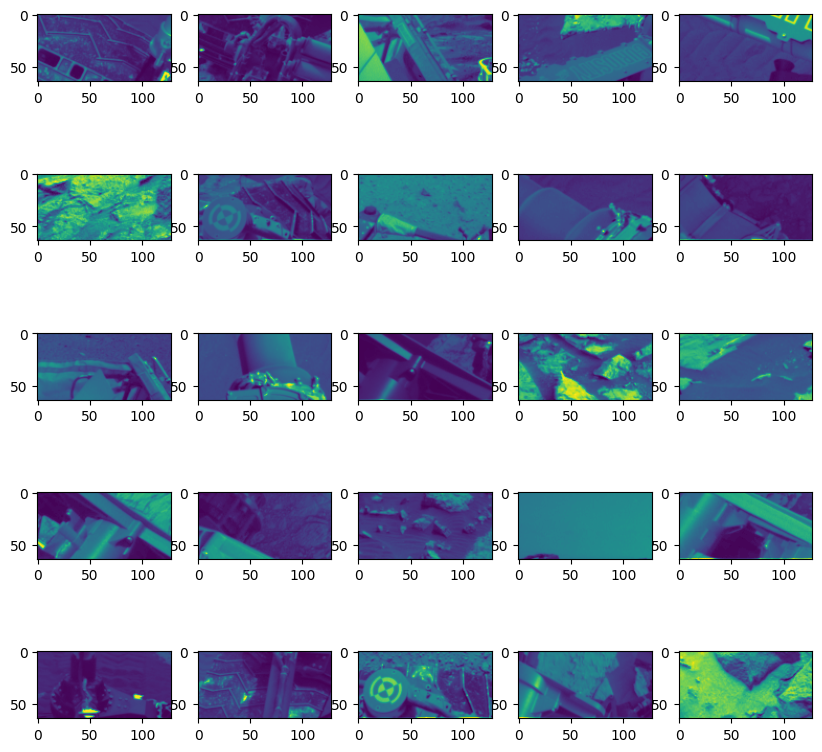

In [ ]:
# Visualize image with indices
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.imshow(X_train[indices[i]])
plt.show()

In [ ]:
# Remove image with a lot of background
remove = 1
if remove == 1:
  X_train = np.delete(X_train, indices, axis=0)
  y_train = np.delete(y_train, indices, axis=0)

#### Final dataset

In [ ]:
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2166, 64, 128)
Training y shape: (2166, 64, 128)
Test X shape: (10022, 64, 128)


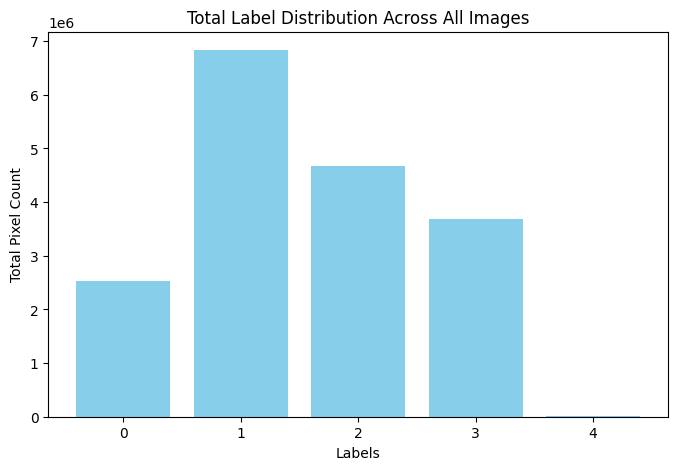

{0.0: 2529450, 2.0: 4664333, 3.0: 3694297, 1.0: 6833957, 4.0: 21835}


In [ ]:
# 2. Dataset-wide label distribution
label_counts_per_image = []
max_label = 0  # Track the highest label number for alignment
total_label_counts = {}

# Iterate over the first 10 label images
for label_img in y_train:  # Only first 10 images
    unique_labels, counts = np.unique(label_img, return_counts=True)
    label_count_dict = dict(zip(unique_labels, counts))
    label_counts_per_image.append(label_count_dict)
    max_label = max(max_label, max(unique_labels))

for label_count in label_counts_per_image:
    for label, count in label_count.items():
        total_label_counts[label] = total_label_counts.get(label, 0) + count

# Plotting total label distribution
plt.figure(figsize=(8, 5))
plt.bar(total_label_counts.keys(), total_label_counts.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Total Pixel Count')
plt.title('Total Label Distribution Across All Images')
plt.show()

print(total_label_counts)

In [ ]:
# Save dataset
np.savez("mars_for_students_processed_noback.npz", X_train=X_train, y_train=y_train, X_test=X_test)

In [ ]:
# Visualize final dataset
plt.figure(figsize=(10,100))
for i in range(100):
    plt.subplot(20, 5, i + 1)
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

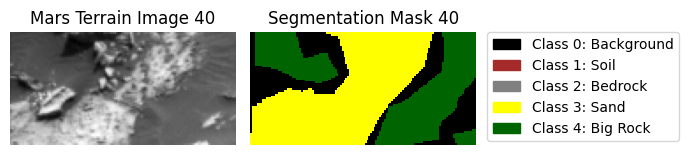

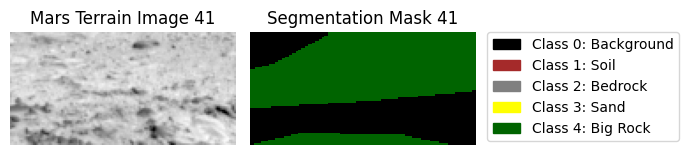

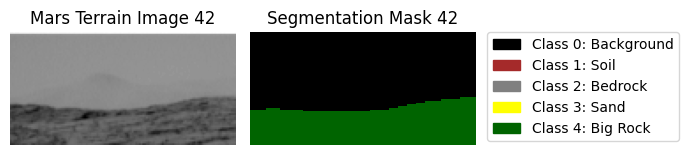

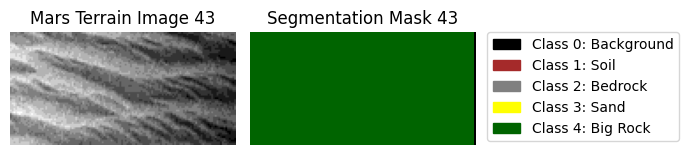

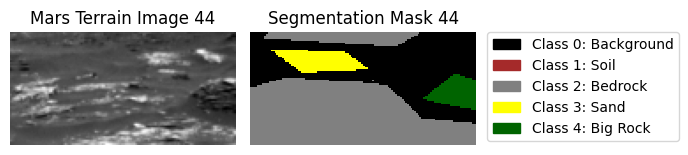

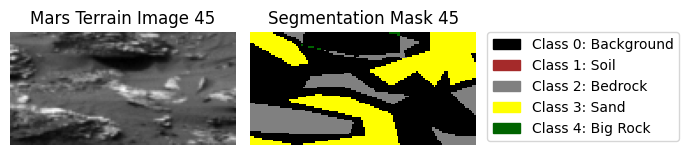

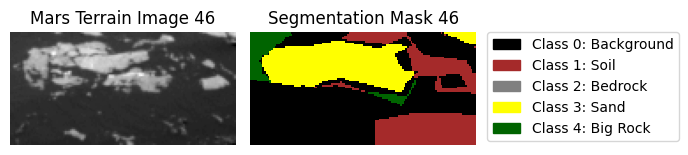

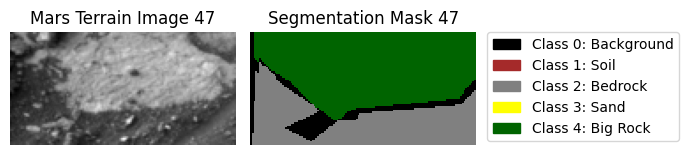

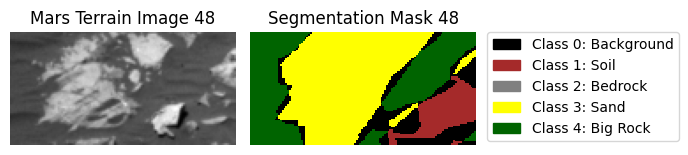

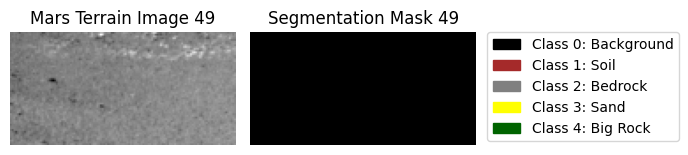

In [ ]:
display_images_with_masks(X_train, y_train, start=40, end=50)